In [58]:
import tensorflow as tf
import numpy as np
from censai import AnalyticalPhysicalModelv2, RIMAnalytic
from censai.definitions import DTYPE
from censai.models import ModelAnalytic
import matplotlib.pyplot as plt
import pandas as pd
import os, json
from argparse import Namespace
from tqdm import tqdm
import matplotlib.pylab as pylab

plt.style.use("science")
params = {'legend.fontsize': 10,
#           'figure.figsize': (10, 10),
         'axes.labelsize': 10,
         'axes.titlesize': 15,#'x-large',
         'xtick.labelsize':10,
         'ytick.labelsize':10,
         'figure.titlesize': 20
         }
pylab.rcParams.update(params)

In [7]:
model = "RIMA_g1_002_A0_TS4_L2_U32_US4_LBG3_Aelu_B128_lr0.001_dr0.8_220131144530"
path = os.path.join(os.getenv("CENSAI_PATH"), "models", model)
with open(os.path.join(path, "script_params.json"), "r") as f:
    params = json.load(f)
args = Namespace()
vars(args).update(params)

phys = AnalyticalPhysicalModelv2(
    pixels=args.pixels,
    image_fov=args.image_fov,
    src_fov=args.src_fov,
    psf_cutout_size=args.psf_cutout_size,
    r_ein_min=args.r_ein_min,
    r_ein_max=args.r_ein_max,
    n_min=args.n_min,
    n_max=args.n_max,
    r_eff_min=args.r_eff_min,
    r_eff_max=args.r_eff_max,
    max_gamma=args.max_gamma,
    max_ellipticity=args.max_ellipticity,
    max_lens_shift=args.max_lens_shift,
    max_source_shift=args.max_source_shift,
    noise_rms_min=args.noise_rms_min,
    noise_rms_max=args.noise_rms_max,
    noise_rms_mean=args.noise_rms_mean,
    noise_rms_std=args.noise_rms_std,
    psf_fwhm_min=args.psf_fwhm_min,
    psf_fwhm_max=args.psf_fwhm_max,
    psf_fwhm_std=args.psf_fwhm_std,
    psf_fwhm_mean=args.psf_fwhm_mean
)
model = ModelAnalytic(
    layers=args.layers,
    units=args.units,
    unit_scaling=args.unit_scaling,
    mlp_before_gru=args.mlp_before_gru,
    activation=args.activation,
    unit_cap=args.unit_cap
)
rim = RIMAnalytic(
    physical_model=phys,
    model=model,
    steps=args.steps,
    adam=args.adam,
)

ckpt = tf.train.Checkpoint(step=tf.Variable(1), net=rim.model)
checkpoint_manager = tf.train.CheckpointManager(ckpt, path, max_to_keep=1)
checkpoint_manager.checkpoint.restore(checkpoint_manager.latest_checkpoint).expect_partial()

In [65]:
# Total prediction done in N * batch_size
N = 100  # Number of time a batch is drawn
batch_size = 10 # batch size

param_list = []
prediction_list = []
cost_list = []
chisq_list = []
for n in tqdm(range(N)): # N=100 is roughly a minute
    lens, params, noise_rms, psf_fwhm = phys.draw_sersic_batch(batch_size)
    y_series, chi_squared = rim.call(lens, noise_rms, psf_fwhm)
    cost = tf.reduce_mean(tf.square(y_series - rim.inverse_link(params)), axis=2)
    cost = tf.reduce_sum(cost, axis=0) # average over recurrent steps
    param_list.append(params.numpy())
    prediction_list.append(rim.link(y_series[-1]).numpy())
    cost_list.append(cost.numpy())
    chisq_list.append(chi_squared.numpy())


100%|██████████| 100/100 [01:03<00:00,  1.58it/s]


In [66]:
if isinstance(param_list, list):
    param_list = np.concatenate(param_list, axis=0)
    prediction_list = np.concatenate(prediction_list, axis=0)
    cost_list = np.concatenate(cost_list, axis=0)
    chisq_list = np.concatenate(chisq_list, axis=1).transpose()

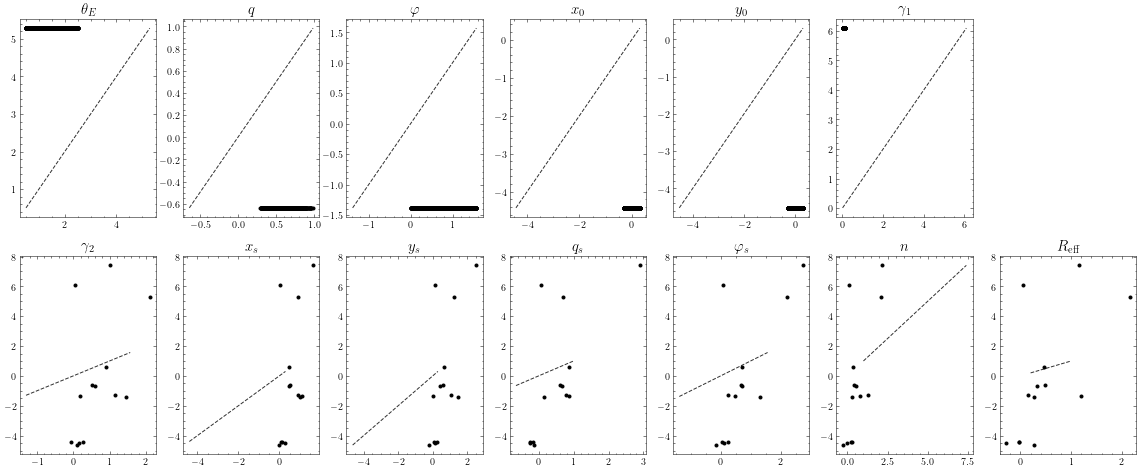

In [67]:
titles = [
    r"$\theta_E$",
    r"$q$",
    r"$\varphi$",
    r"$x_0$",
    r"$y_0$",
    r"$\gamma_1$",
    r"$\gamma_2$",
    r"$x_s$",
    r"$y_s$",
    r"$q_s$",
    r"$\varphi_s$",
    r"$n$",
    r"$R_{\mathrm{eff}}$"
]
fig, axs = plt.subplots(2, 7, figsize=(20, 8))
for i in range(6):
    axs[0, i].plot(param_list[:, i], prediction_list[:, i], ".k")
    x_min = min(param_list[:, i].min(), prediction_list[:, i].min())
    x_max = max(param_list[:, i].max(), prediction_list[:, i].max())
    axs[0, i].plot([x_min, x_max], [x_min, x_max], "k--", alpha=0.8)
    axs[0, i].set_title(titles[i])
    
for i in range(7):
    axs[1, i].plot(param_list[i+6], prediction_list[i+6], ".k")
    x_min = min(param_list[:, i+6].min(), prediction_list[:, i+6].min())
    x_max = max(param_list[:, i+6].max(), prediction_list[:, i+6].max())
    axs[1, i].plot([x_min, x_max], [x_min, x_max], "k--", alpha=0.8)
    axs[1, i].set_title(titles[i+6])
axs[0, -1].axis("off");

In [61]:
param_list[:10, 6]

array([1.7919028, 2.1825097, 2.3208807, 1.4756281, 0.6456609, 1.019521 ,
       1.7247307, 1.5149515, 2.1951594, 1.9260759], dtype=float32)

In [62]:
prediction_list[:10, 6]

array([5.286643, 5.286643, 5.286643, 5.286643, 5.286643, 5.286643,
       5.286643, 5.286643, 5.286643, 5.286643], dtype=float32)